In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from molecular_mpns.config import fig_dir
import os

os.chdir(fig_dir)

In [7]:
# define double well system
class DoubleWell:
    
    def __init__(self,a=0.25,b=3,c=1,d=0.5):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        
    
    def U(self,x):
        return self.a*x[0,:]**4 - self.b*x[0,:]**2 + self.c*x[0,:] + self.d*x[1,:]**2
    
    def gradU(self,x):
        return np.vstack([4*self.a*x[0,:]**3 - 2*self.b*x[0,:] + self.c,2*self.d*x[1,:]])
    
def MALA(system,x,dt,beta):
    accepted = False
    while not accepted:
        U,dU = system.U(x),system.gradU(x)
        pi = np.exp(-beta*U)
        
        w = np.random.randn(2,1)
        x_prop = x - beta*dU*dt + np.sqrt(2*dt)*w
        
        U_prop,dU_prop = system.U(x_prop), system.gradU(x_prop)
        pi_prop = np.exp(-beta*U_prop)
        
        q,q_prop = np.exp((-0.25/dt)*((x_prop - x + dt*beta*dU)**2).sum()),np.exp((-0.25/dt)*((x - x_prop + dt*beta*dU_prop)**2).sum())
        
        alpha = (pi_prop/pi)*(q/q_prop)
        
        u = np.random.rand()
        accepted = u < alpha 
        
    return x_prop
    

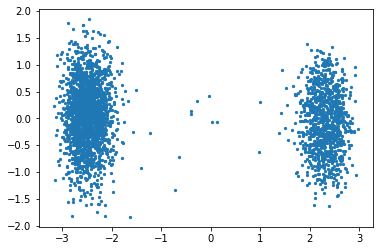

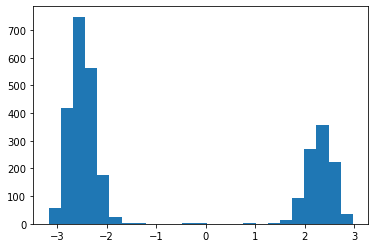

In [8]:
# simulate training trajectory
system = DoubleWell()
N,N_traj = 1000,3
beta,dt = 1,1e-1
train = []


np.random.seed(42)
for n in range(N_traj):
    x = np.array([[0],[0]])
    short_traj = np.zeros((2,N))
    for t in range(N):
        x = MALA(system,x,dt,beta)
        short_traj[:,t] = x.flatten()
    train.append(short_traj)

train = np.hstack(train)
plt.scatter(train[0,:],train[1,:],s = 5)
plt.show()
plt.close()

plt.hist(train[0,:],bins = 25,density = False)
plt.show()
plt.close()

In [41]:
# create train/test split and data loader
np.random.seed(40)
N_train = 1000
X = train.T
X = X[np.random.choice(X.shape[0],X.shape[0],replace = False)]

X_train,X_val = X[0:N_train],X[N_train:]
X_train,X_val = torch.tensor(X_train),torch.tensor(X_val)

batch_size = 32
training_dataset = TensorDataset(X_train)
training_loader = DataLoader(training_dataset,batch_size = batch_size)

In [46]:
# define model

class VAE(torch.nn.Module):
    
    def __init__(self,xdim=2,zdim=1,training = True):
        
        super(VAE,self).__init__()
        
        d1,d2,d3 = 256,256,256 # hidden dimensions in network
        self.training = training
        self.xdim = xdim
        
        # encoder
        self.enc_lin1 = torch.nn.Linear(xdim,d1)
        self.enc_lin2 = torch.nn.Linear(d1,d2)
        self.enc_lin3 = torch.nn.Linear(d2,d3)
        
        self.enc_mu = torch.nn.Linear(d3,zdim)
        self.enc_logvar = torch.nn.Linear(d3,zdim)
    
        # decoder
        self.dec_lin1 = torch.nn.Linear(zdim,d1)
        self.dec_lin2 = torch.nn.Linear(d1,d2)
        
        #self.dec_logvar = torch.nn.Parameter(torch.zeros(xdim), requires_grad=True)
        self.dec_logvar = torch.nn.Linear(d2,xdim)
        self.dec_mu = torch.nn.Linear(d2,xdim)
        
    def encode(self,x):
        
        h = self.enc_lin1(x)
        h = torch.nn.functional.selu(h)
        h = self.enc_lin2(h)
        h = torch.nn.functional.selu(h)
        h = self.enc_lin3(h)
        h = torch.tanh(h)
        
        mu_enc = self.enc_mu(h)
        logvar_enc = self.enc_logvar(h)
        
        return mu_enc, logvar_enc
    
    def reparameterize(self,mu_enc,mu_logvar):
        
        sigma = torch.exp(0.5*mu_logvar)
        eps = torch.randn_like(sigma)
        z = mu_enc + (sigma*eps)
        
        return z if self.training else mu_enc
    
    def decode(self,z):
        
        h = self.dec_lin1(z)
        h = torch.tanh(h)
        h = self.dec_lin2(h)
        h = torch.tanh(h)
        
        mu_dec = self.dec_mu(h)
        
        #batch_size = mu_dec.shape[0]
        #logvar_dec = self.dec_logvar.repeat(batch_size, 1)
        logvar_dec = self.dec_logvar(h)
        
        return mu_dec, logvar_dec
    
    def forward(self, x):
        mu_enc, logvar_enc = self.encode(x.view(-1, self.xdim))
        z = self.reparameterize(mu_enc, logvar_enc)
        return self.decode(z), mu_enc, logvar_enc
    
def VAEloss(mu_dec,logvar_dec,x,mu_enc,logvar_enc,L,xdim = 2):
    
    # recon loss for p(x | z)
    pointwiseMSEloss = 0.5*torch.nn.functional.mse_loss(mu_dec,x.view(-1,xdim),reduction = 'none')
    sigsq = torch.exp(logvar_dec)
    weight = 1/sigsq
    pointwiseWeightedMSEloss = pointwiseMSEloss*weight
    WeightedMSEloss = pointwiseWeightedMSEloss.sum()
    
    logvarobjective = 0.5 * logvar_dec.sum() # scaling factor term for p(x|z)
    
    # KLD loss for q(z | x)
    KLD = -0.5 * torch.sum(1 + logvar_enc - mu_enc**2 - torch.exp(logvar_enc))
    
    loss = (KLD + (1/L)*WeightedMSEloss + logvarobjective)
    
    return loss

<ipython-input-47-d52e32d8e87a>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(dataaug).to(device)


Epoch 1 Loss: -606429.6829104924


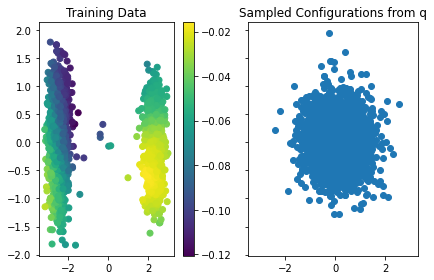

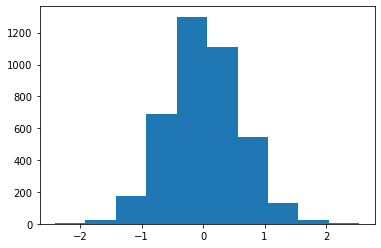

Epoch 2 Loss: -1763819.768323475


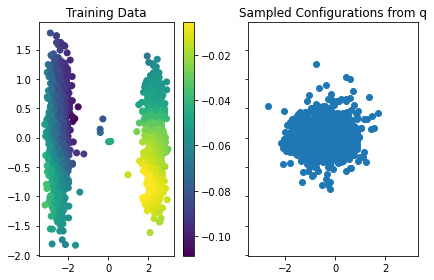

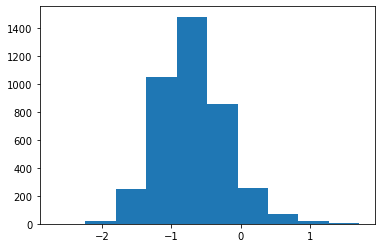

Epoch 3 Loss: -2054208.3272469966


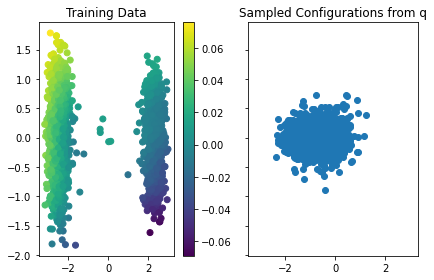

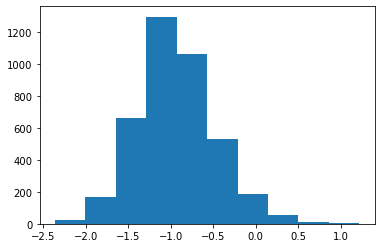

Epoch 4 Loss: -2072019.9531466377


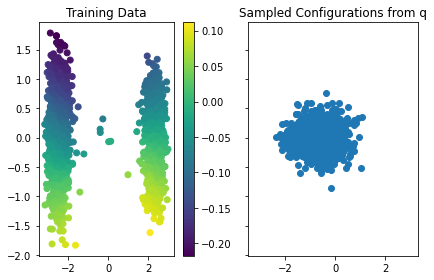

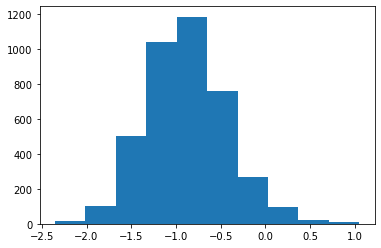

Epoch 5 Loss: -2085182.7841609372


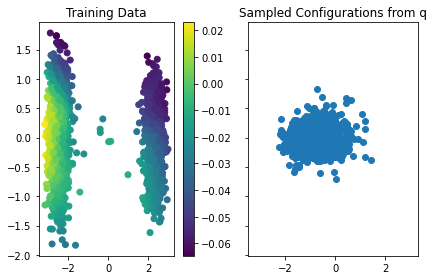

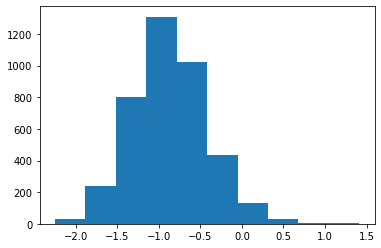

Epoch 6 Loss: -2090992.4500582488


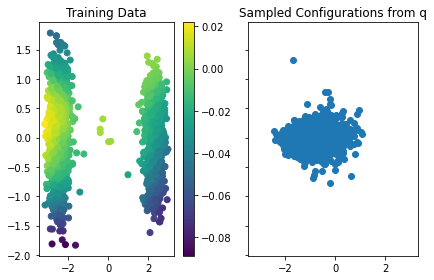

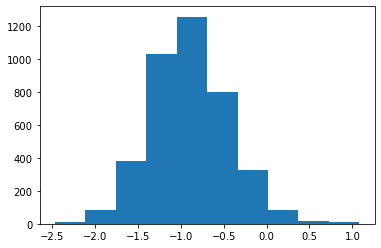

Epoch 7 Loss: -2100187.1000601323


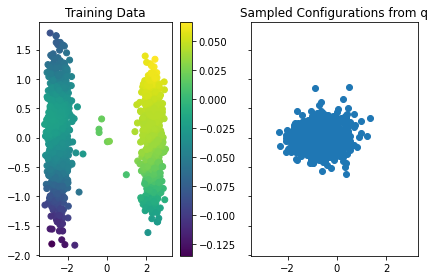

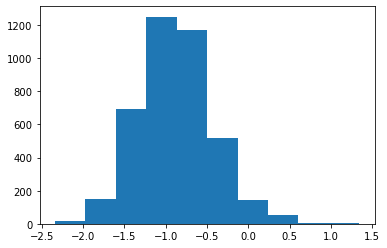

Epoch 8 Loss: -2103274.990003252


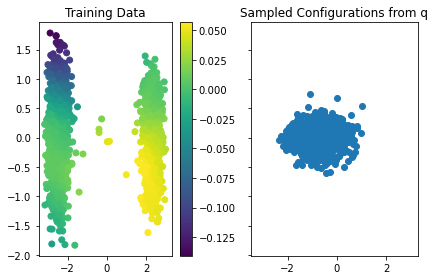

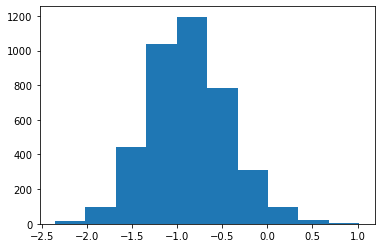

Epoch 9 Loss: -2109424.841639373


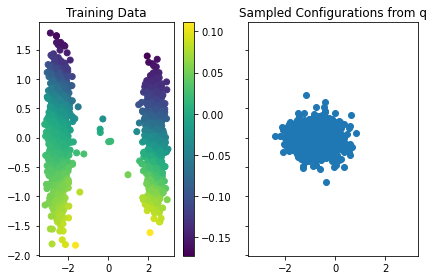

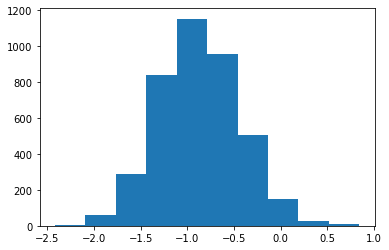

Epoch 10 Loss: -2112183.36800774


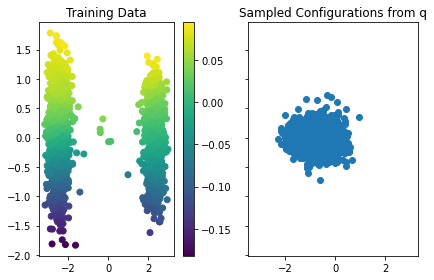

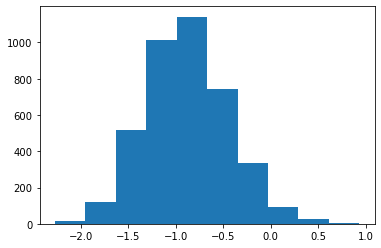

Epoch 11 Loss: -2117080.001733621


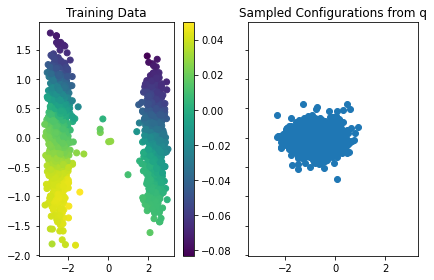

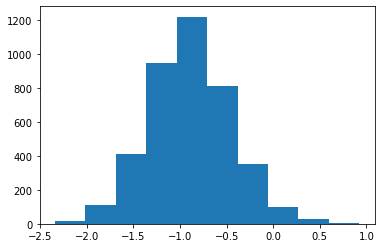

Epoch 12 Loss: -2121654.5226289053


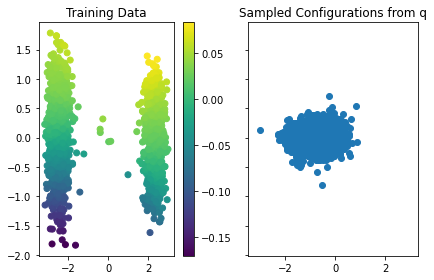

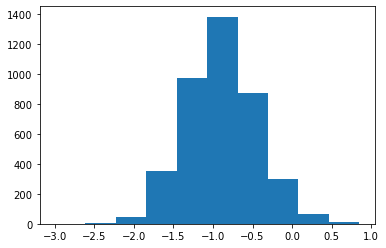

Epoch 13 Loss: -2123570.46549097


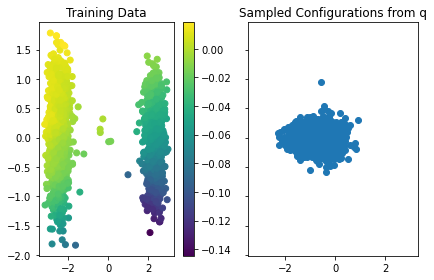

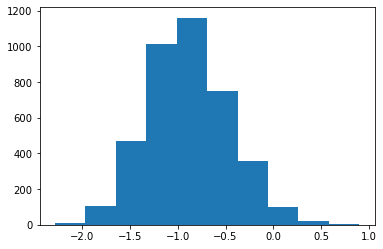

Epoch 14 Loss: -2125884.008715491


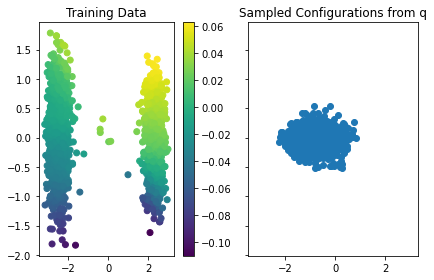

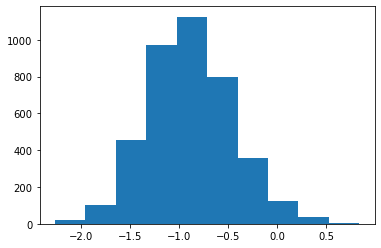

Epoch 15 Loss: -2129840.1833180618


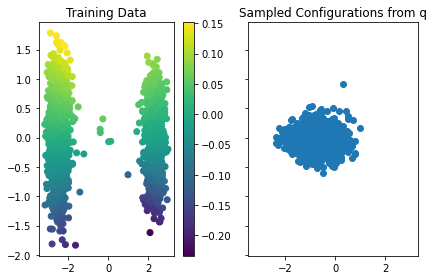

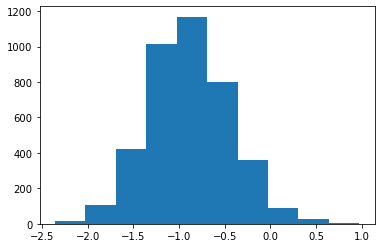

Epoch 16 Loss: -2130526.162419269


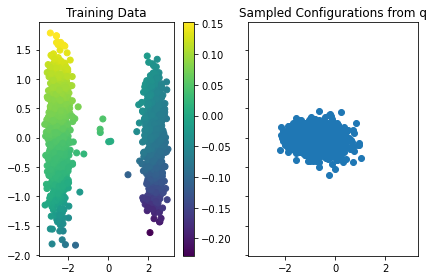

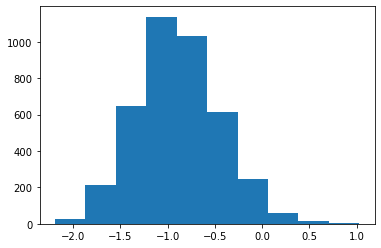

Epoch 17 Loss: -2132928.452521926


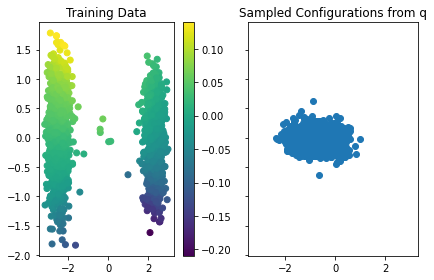

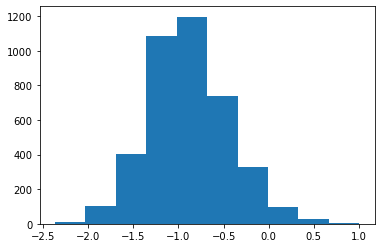

Epoch 18 Loss: -2132812.1716911243


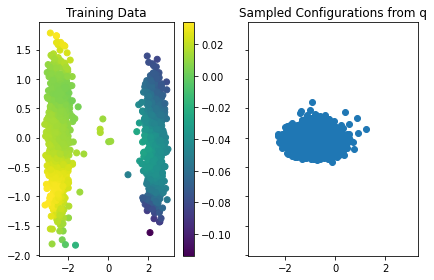

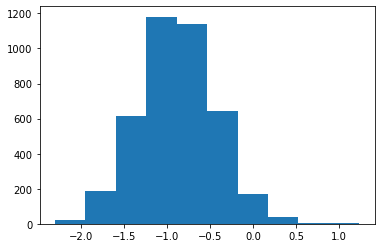

Epoch 19 Loss: -2135691.49499494


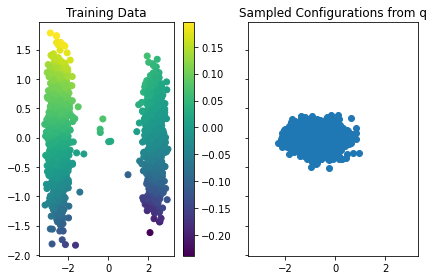

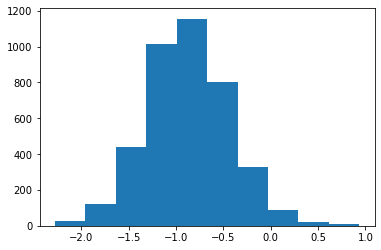

Epoch 20 Loss: -2135405.8089207876


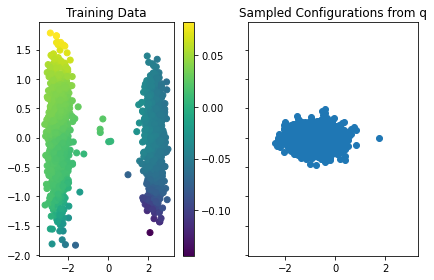

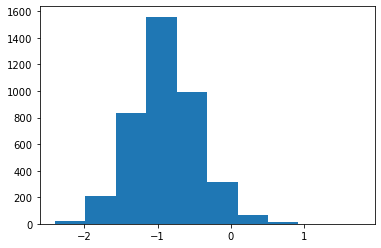

Epoch 21 Loss: -2137507.5815503807


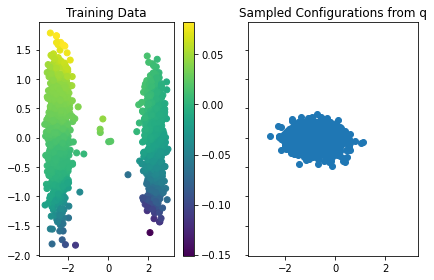

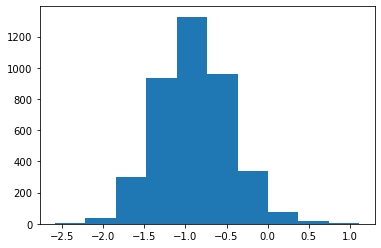

Epoch 22 Loss: -2138029.578950665


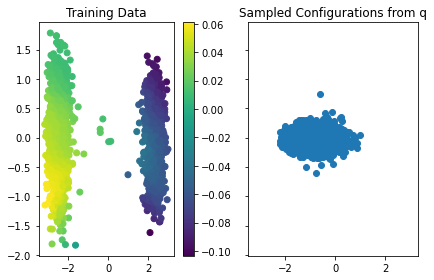

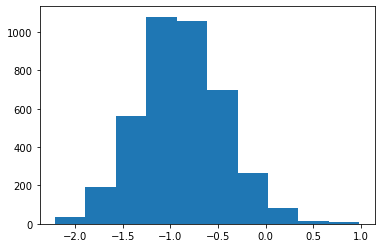

Epoch 23 Loss: -2140064.8409710014


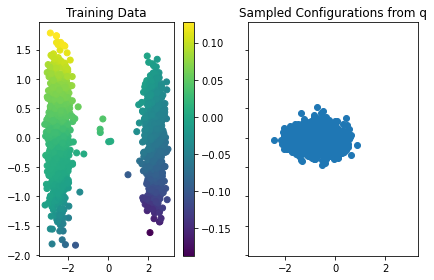

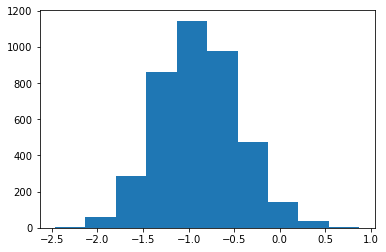

Epoch 24 Loss: -2137591.8637886303


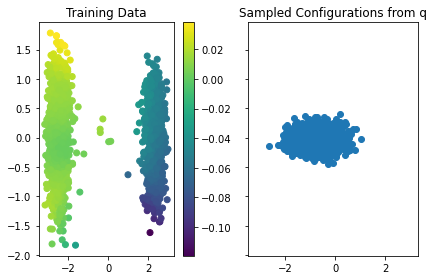

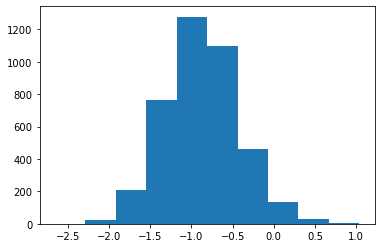

Epoch 25 Loss: -2139453.7975815022


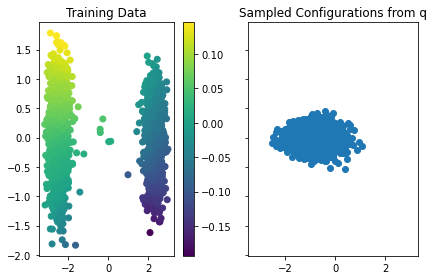

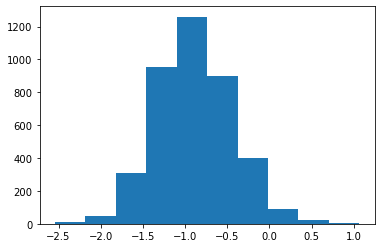

Epoch 26 Loss: -2140623.861161827


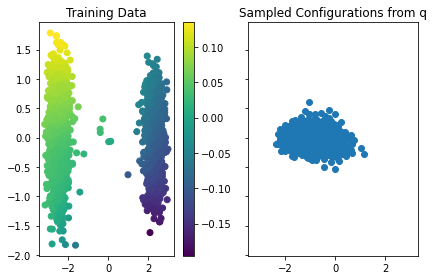

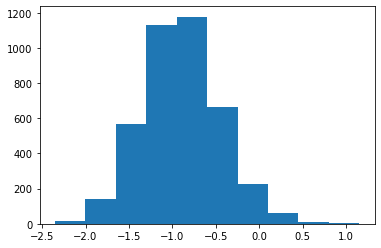

Epoch 27 Loss: -2143068.9854112267


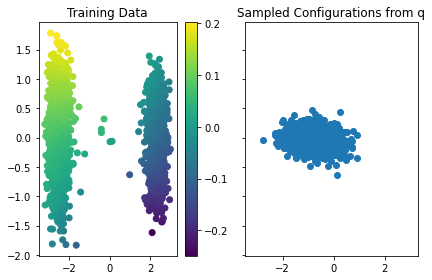

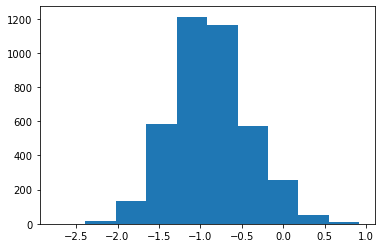

Epoch 28 Loss: -2141407.5128097725


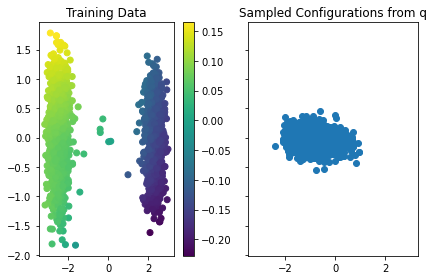

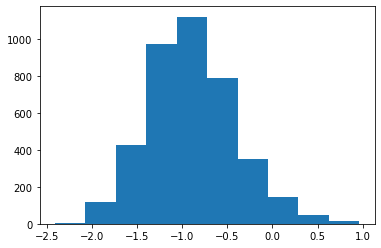

Epoch 29 Loss: -2141529.683129581


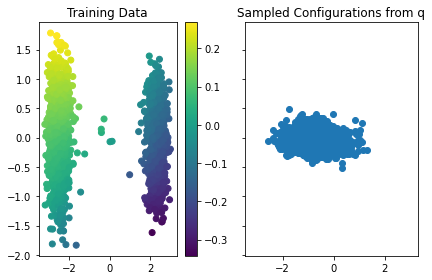

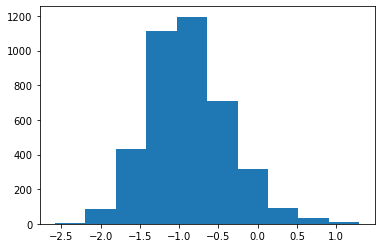

Epoch 30 Loss: -2142090.767911626


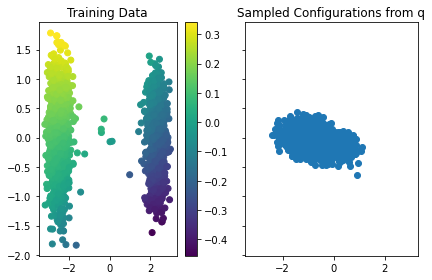

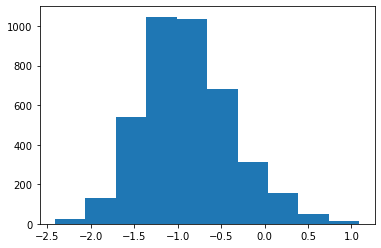

Epoch 31 Loss: -2145146.72229146


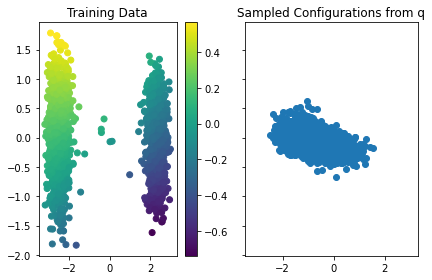

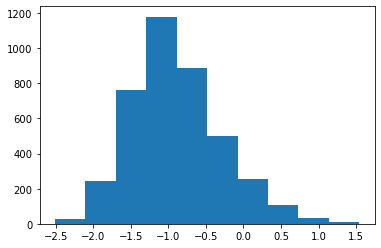

Epoch 32 Loss: -2149671.6783406963


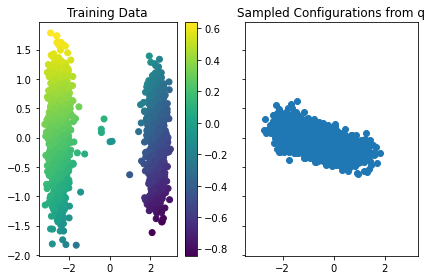

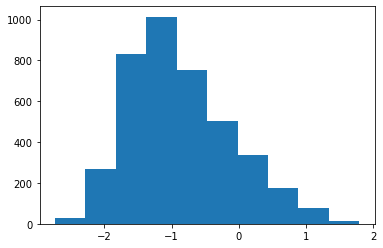

Epoch 33 Loss: -2165896.602498052


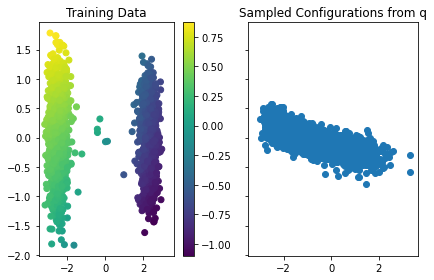

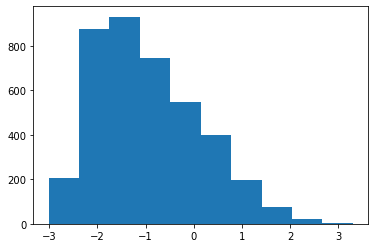

Epoch 34 Loss: -2293975.8830123367


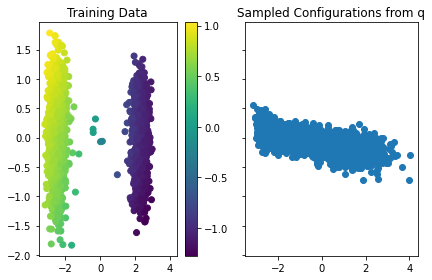

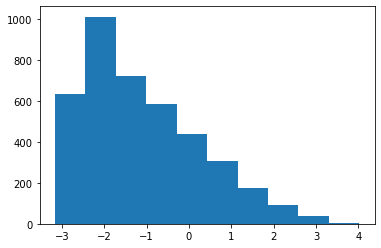

Epoch 35 Loss: -2534754.409653602


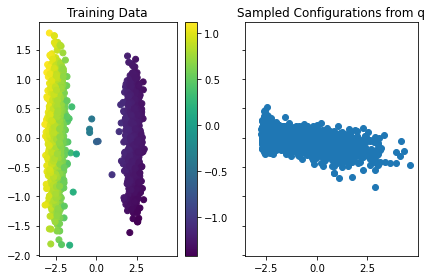

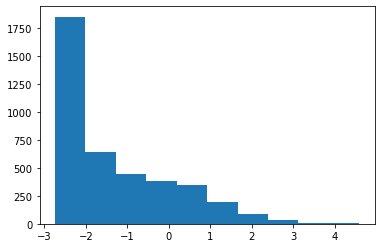

Epoch 36 Loss: -2656096.1186547903


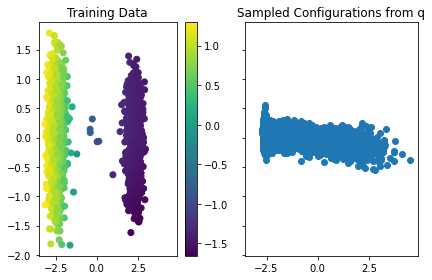

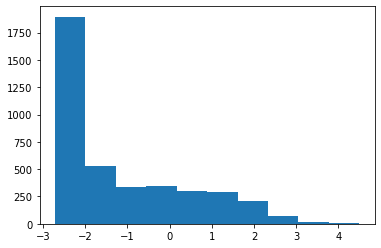

Epoch 37 Loss: -2742139.404163348


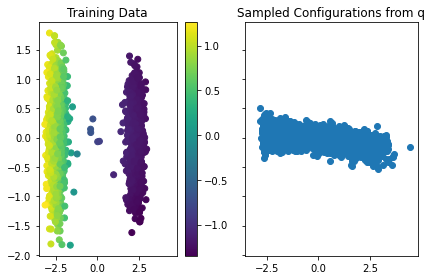

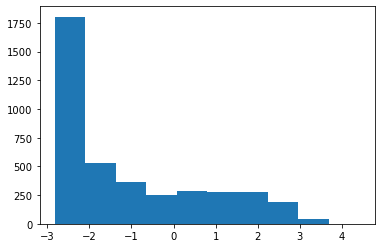

Epoch 38 Loss: -2850847.7866065586


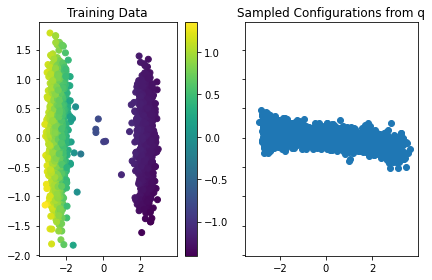

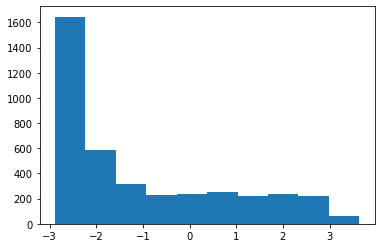

Epoch 39 Loss: -2905780.4040444945


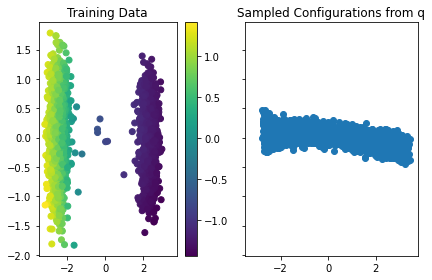

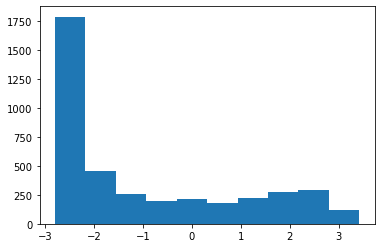

Epoch 40 Loss: -2985503.18343035


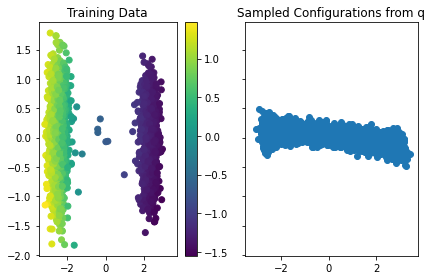

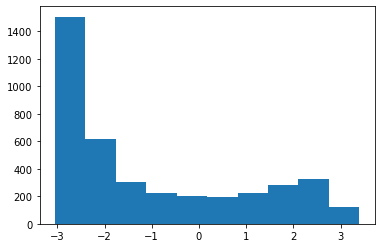

Epoch 41 Loss: -3037726.367791184


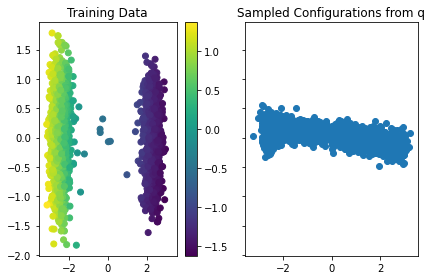

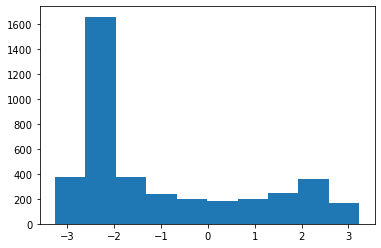

Epoch 42 Loss: -3091459.757275434


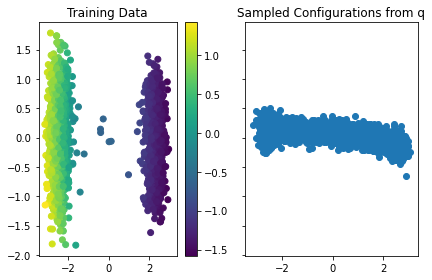

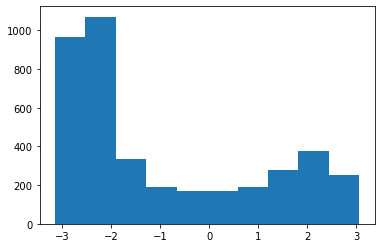

Epoch 43 Loss: -3111449.4242568384


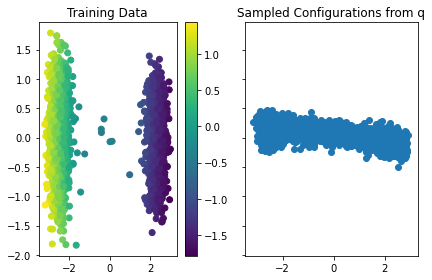

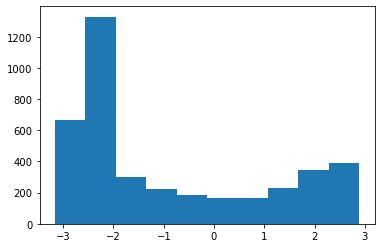

Epoch 44 Loss: -3166560.299504207


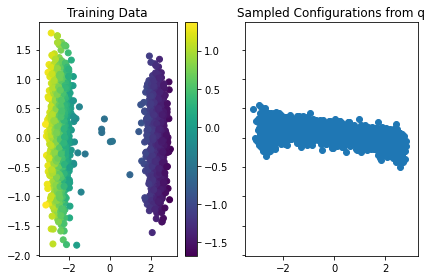

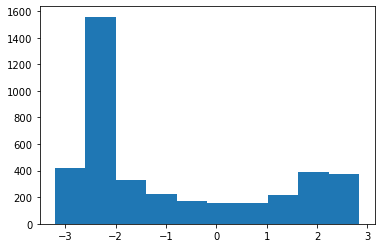

Epoch 45 Loss: -3202204.9556435524


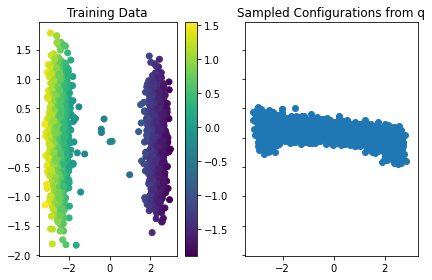

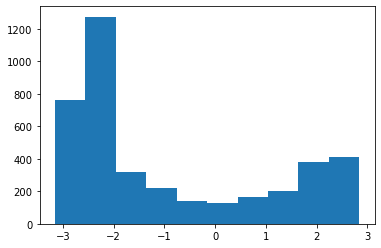

Epoch 46 Loss: -3219668.1264322107


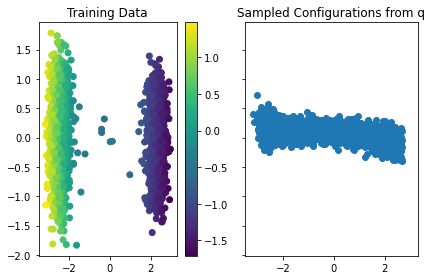

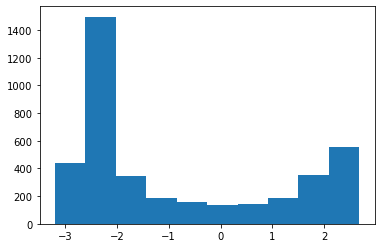

Epoch 47 Loss: -3237974.022850717


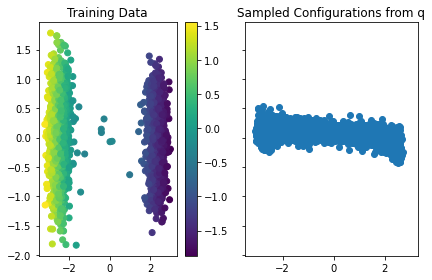

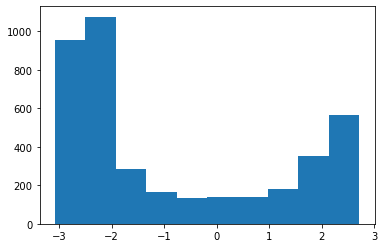

Epoch 48 Loss: -3260645.646534342


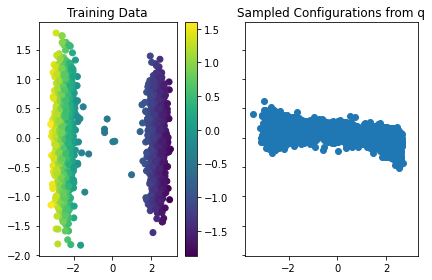

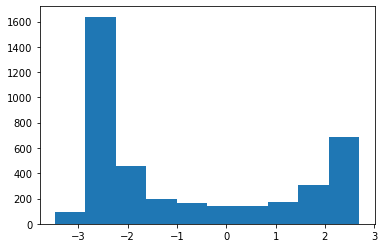

Epoch 49 Loss: -3272185.2564408407


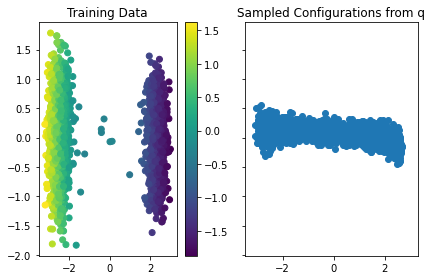

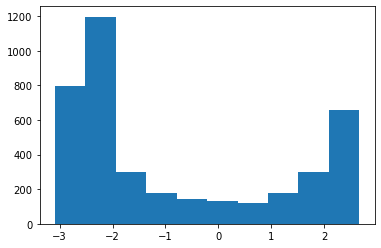

Epoch 50 Loss: -3301654.4896334494


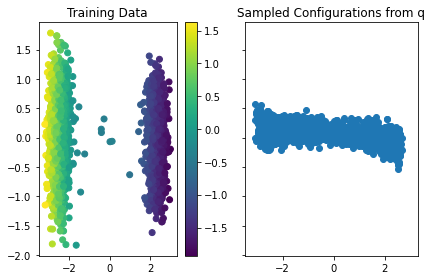

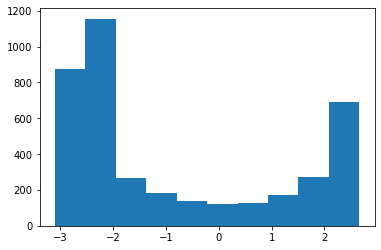

Epoch 51 Loss: -3310432.342839432


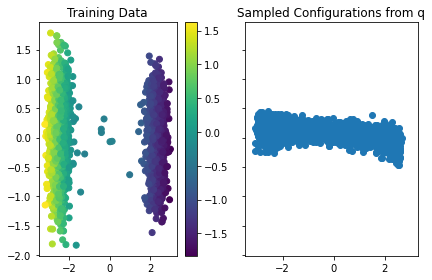

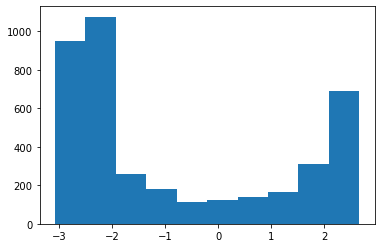

Epoch 52 Loss: -3318389.6393324076


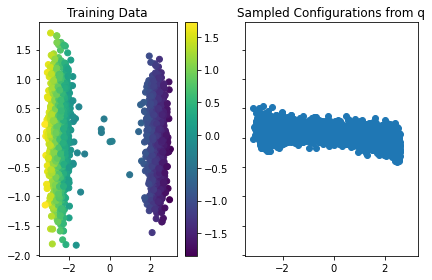

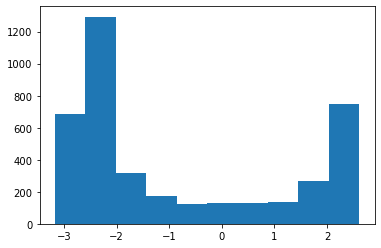

Epoch 53 Loss: -3326626.67945069


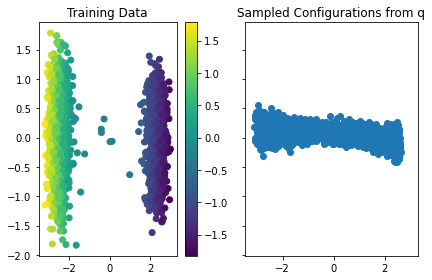

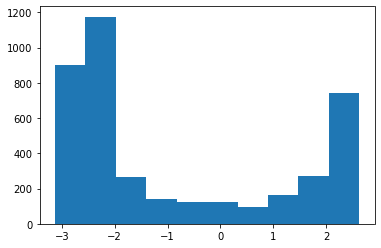

Epoch 54 Loss: -3336882.6393675925


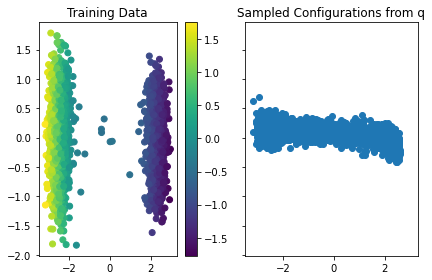

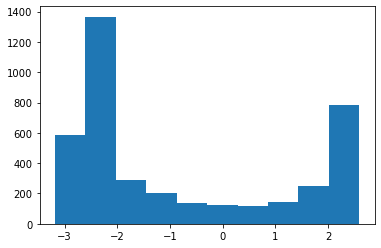

Epoch 55 Loss: -3343465.662097263


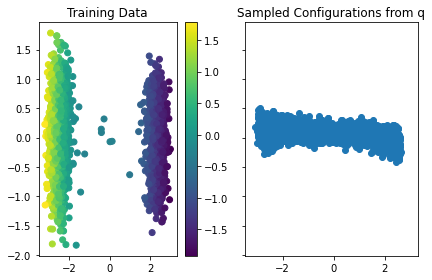

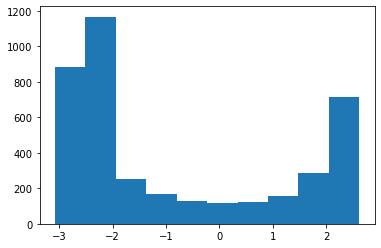

Epoch 56 Loss: -3361950.3296043565


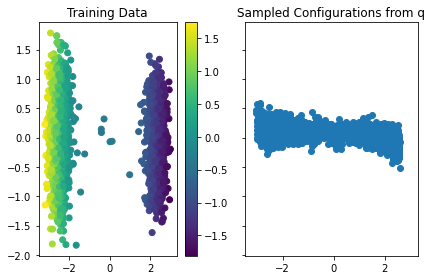

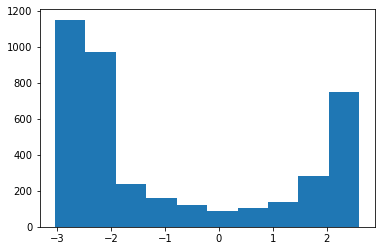

Epoch 57 Loss: -3367929.826386478


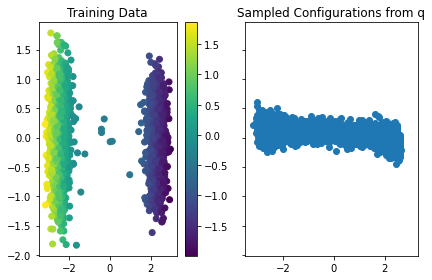

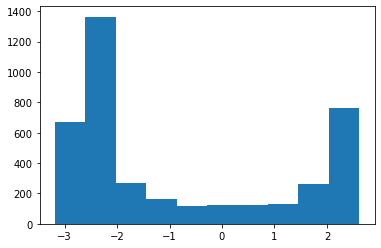

Epoch 58 Loss: -3370712.9882702613


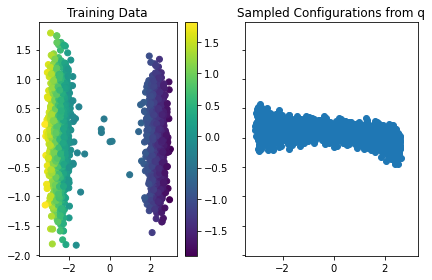

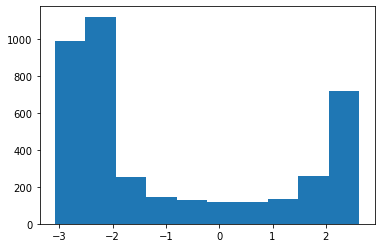

Epoch 59 Loss: -3377478.6172422078


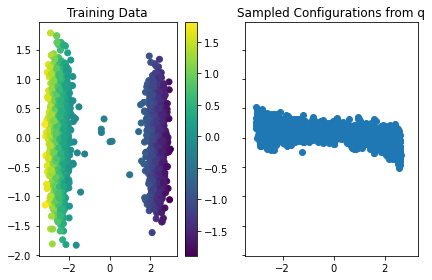

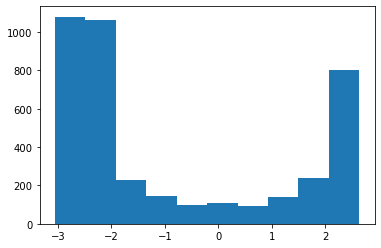

Epoch 60 Loss: -3385006.7554369103


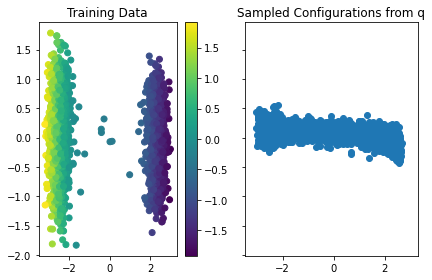

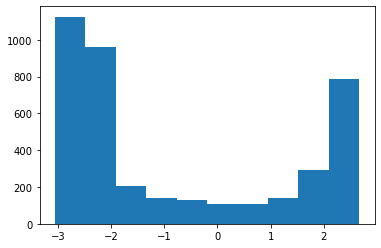

Epoch 61 Loss: -3404267.369866634


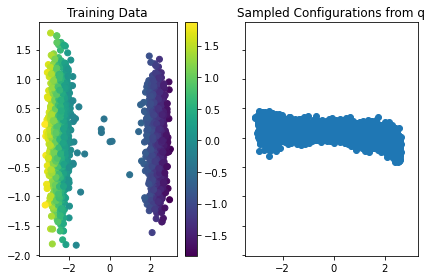

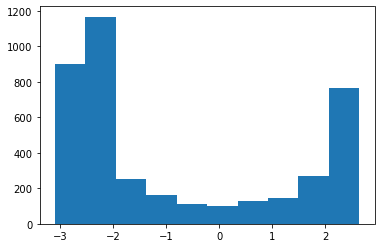

Epoch 62 Loss: -3398989.8539860053


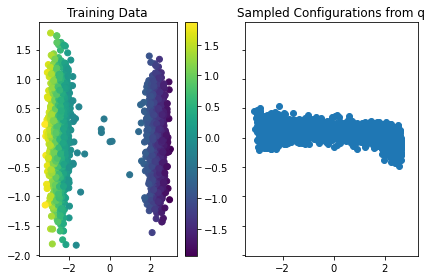

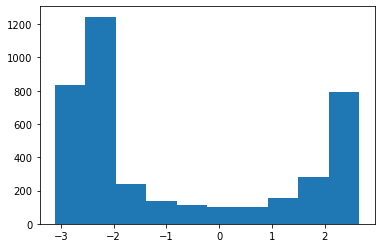

Epoch 63 Loss: -3419493.4372054627


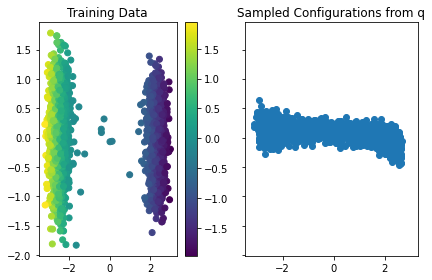

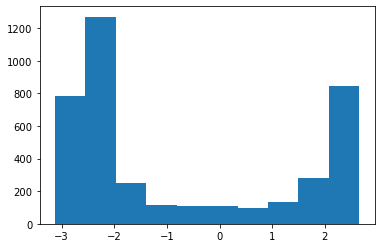

Epoch 64 Loss: -3416371.832923473


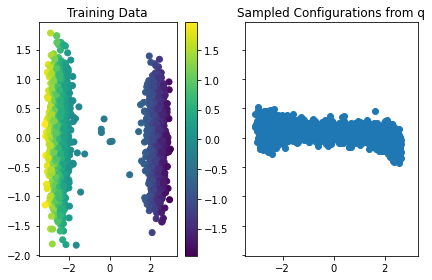

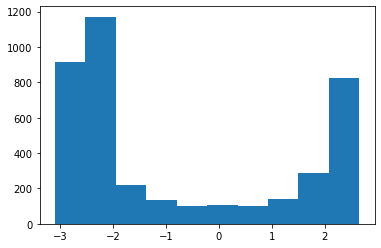

Epoch 65 Loss: -3423669.83866681


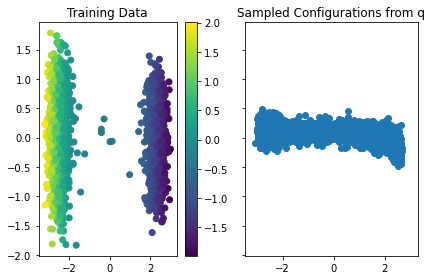

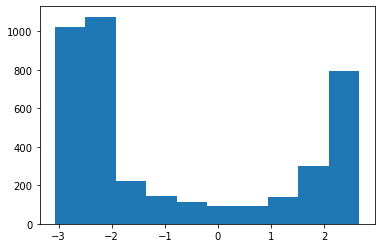

Epoch 66 Loss: -3398388.423951031


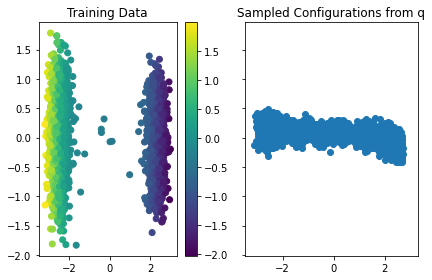

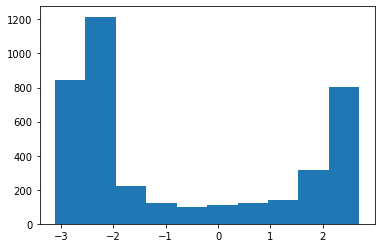

Epoch 67 Loss: -3437010.22300014


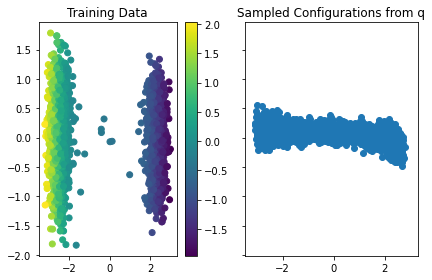

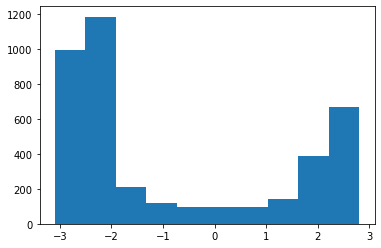

Epoch 68 Loss: -3438769.1058907085


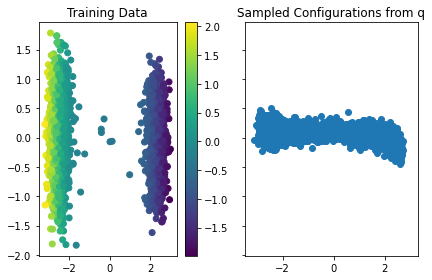

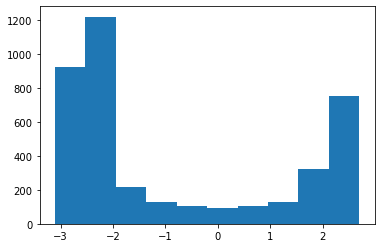

Epoch 69 Loss: -3444082.0466014035


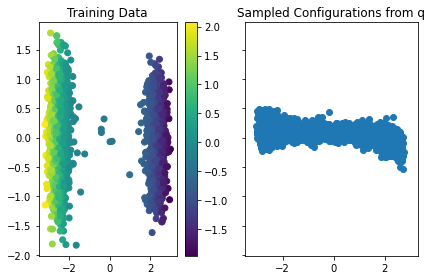

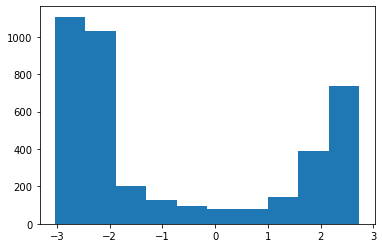

Epoch 70 Loss: -3447758.9935095133


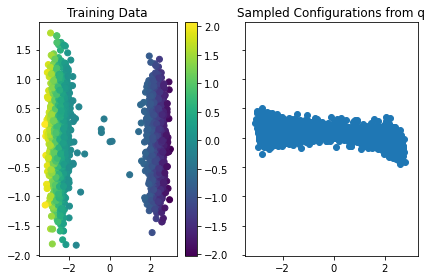

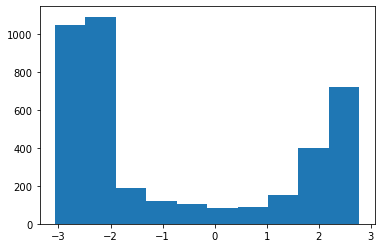

Epoch 71 Loss: -3457890.1667739875


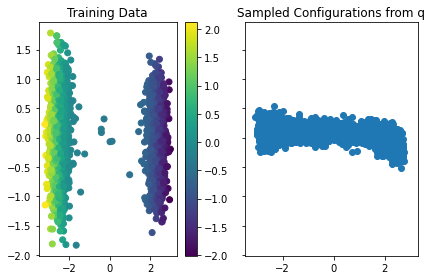

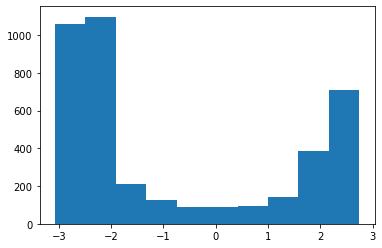

Epoch 72 Loss: -3464509.8220751695


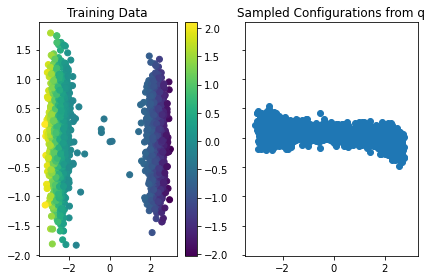

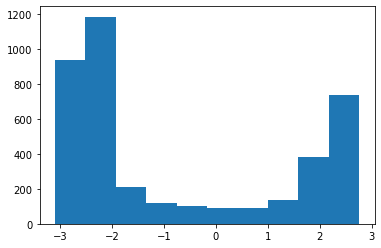

Epoch 73 Loss: -3470095.6696157167


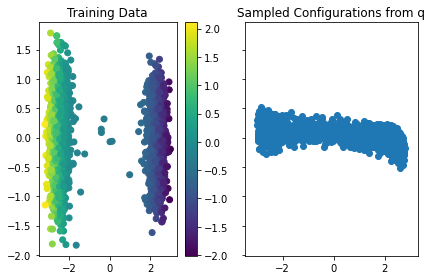

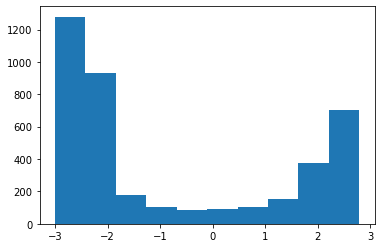

Epoch 74 Loss: -3460207.965877533


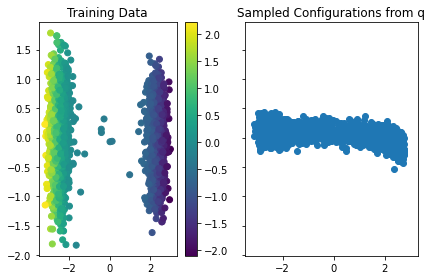

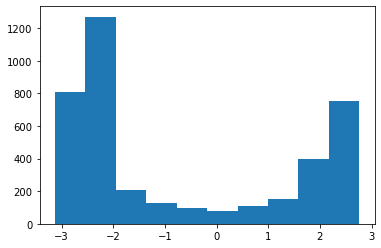

Epoch 75 Loss: -3468293.2412906517


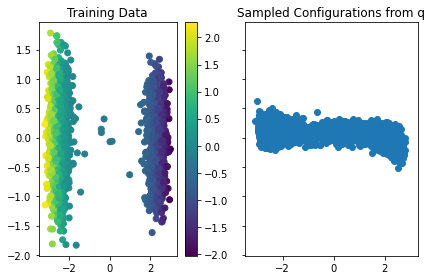

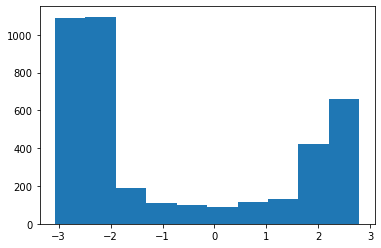

Epoch 76 Loss: -3482503.6667009243


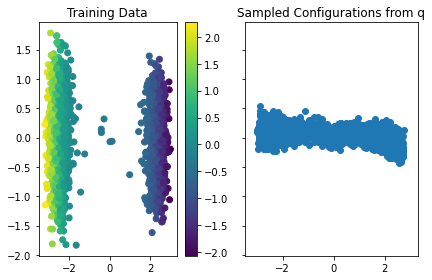

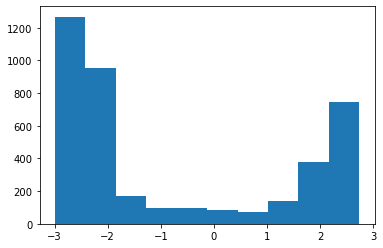

Epoch 77 Loss: -3457579.21709347


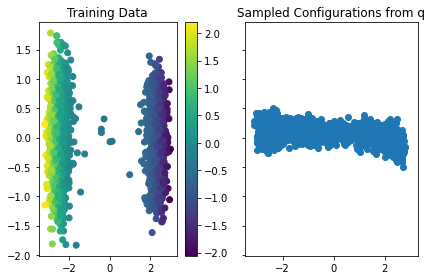

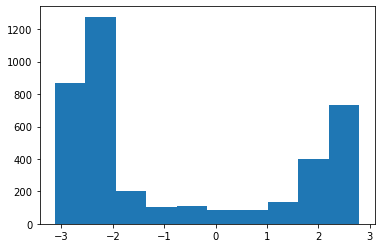

Epoch 78 Loss: -3479643.018409262


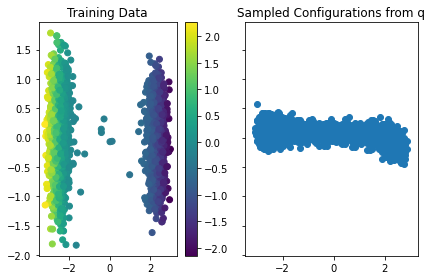

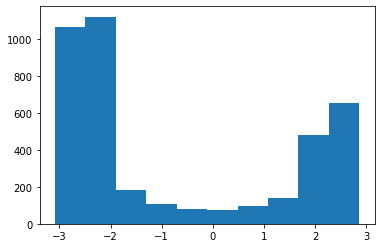

Epoch 79 Loss: -3475572.3351140157


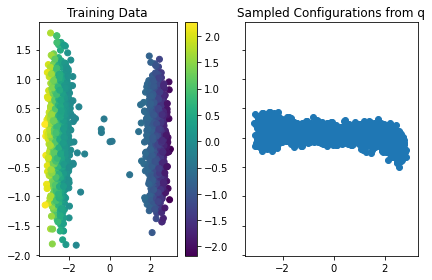

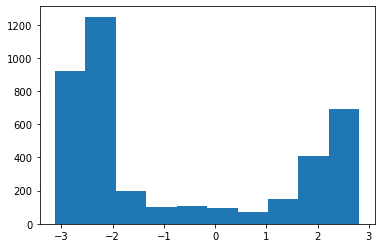

Epoch 80 Loss: -3504675.00027685


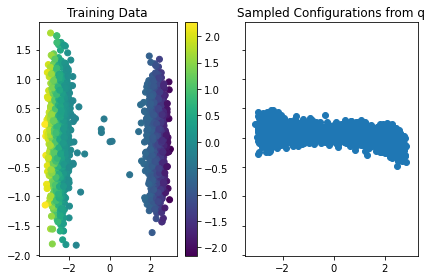

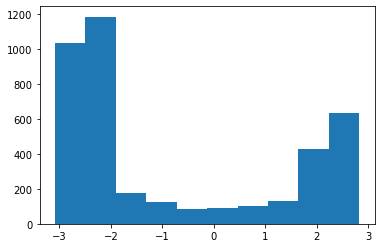

Epoch 81 Loss: -3514492.573547901


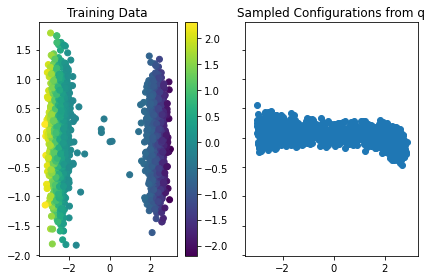

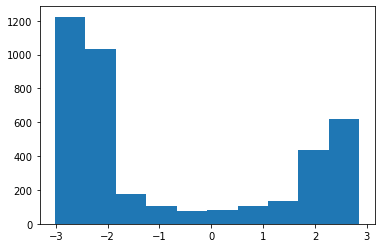

Epoch 82 Loss: -3502917.7927195122


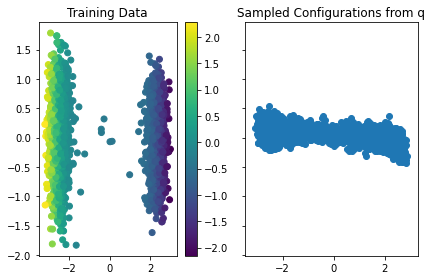

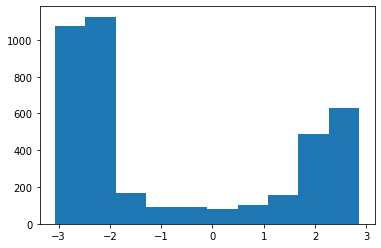

Epoch 83 Loss: -3505504.120353917


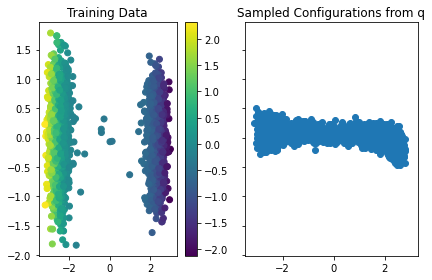

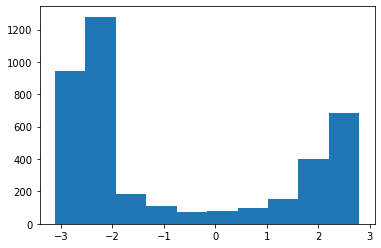

Epoch 84 Loss: -3518802.4282604856


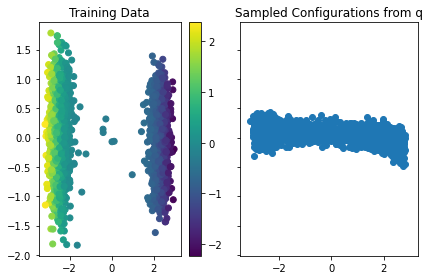

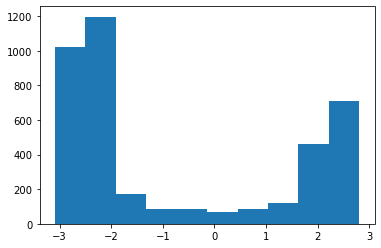

Epoch 85 Loss: -3523922.7202156335


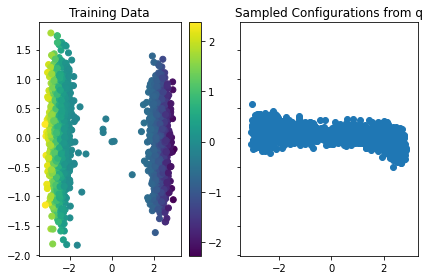

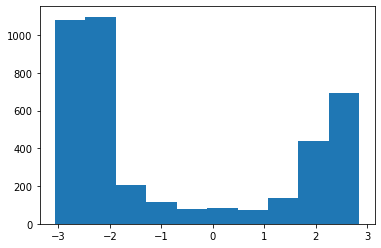

Epoch 86 Loss: -3511998.028436218


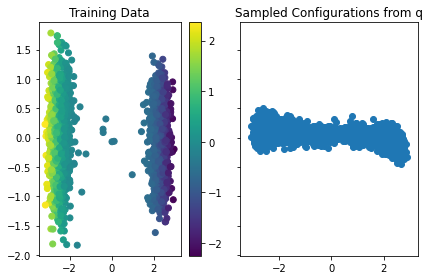

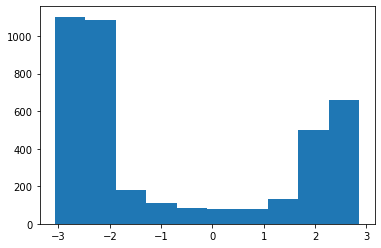

Epoch 87 Loss: -3521417.983858964


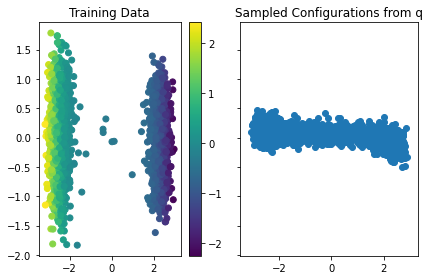

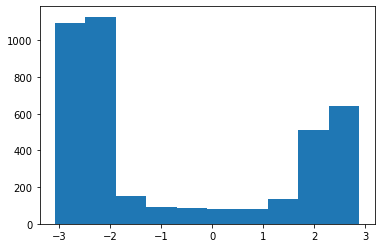

Epoch 88 Loss: -3530703.5901800506


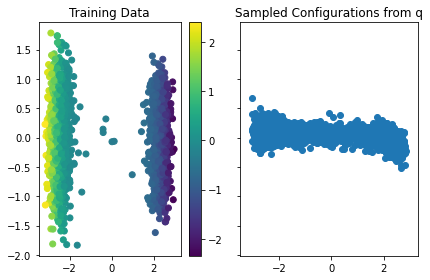

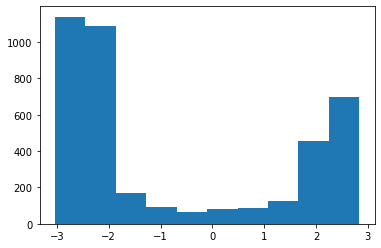

Epoch 89 Loss: -3493941.251156298


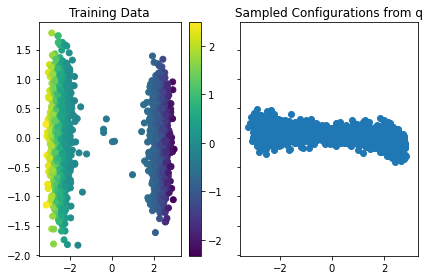

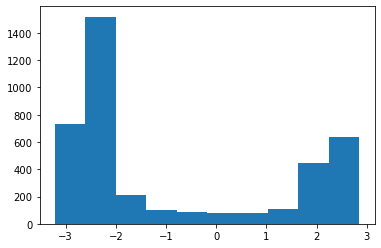

Epoch 90 Loss: -3526231.838593868


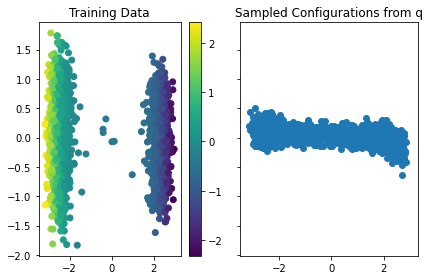

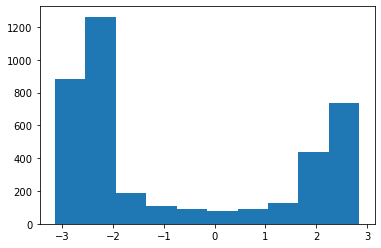

Epoch 91 Loss: -3532910.302092189


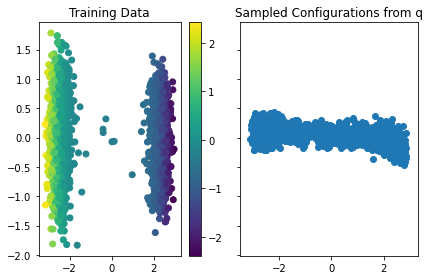

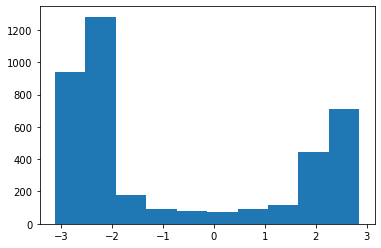

Epoch 92 Loss: -3520753.5579816448


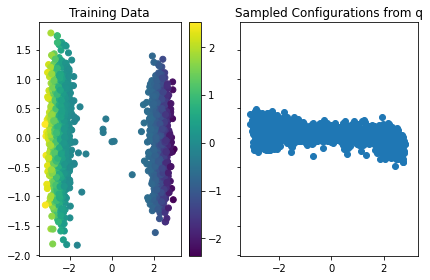

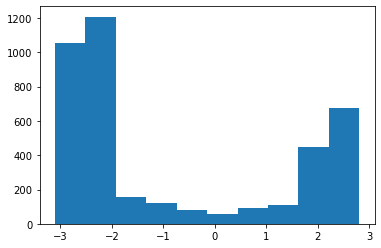

Epoch 93 Loss: -3511654.005629629


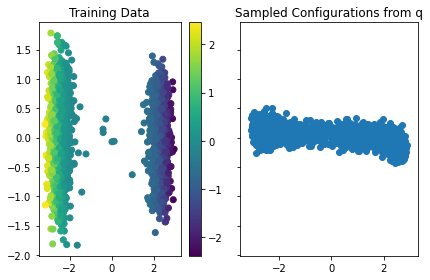

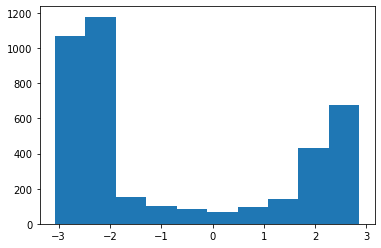

Epoch 94 Loss: -3527752.3364371876


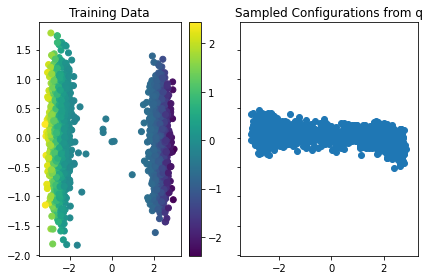

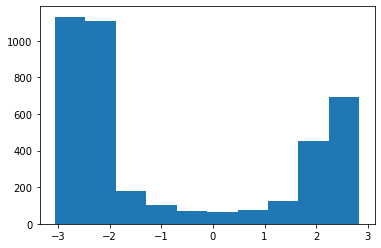

Epoch 95 Loss: -3518878.8320219


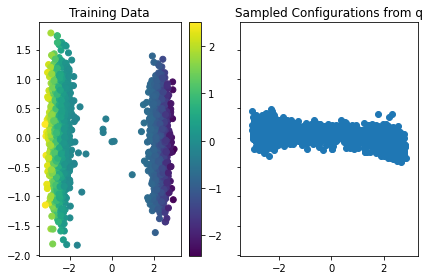

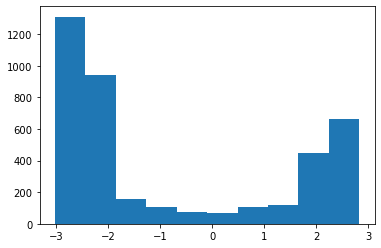

Epoch 96 Loss: -3515681.128309084


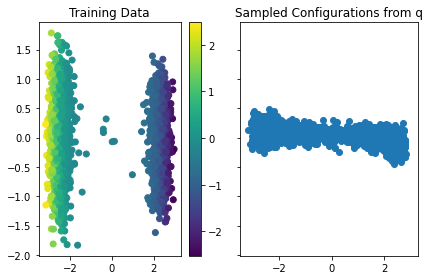

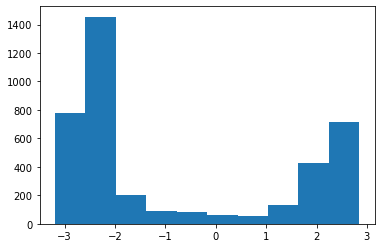

Epoch 97 Loss: -3526294.5755681745


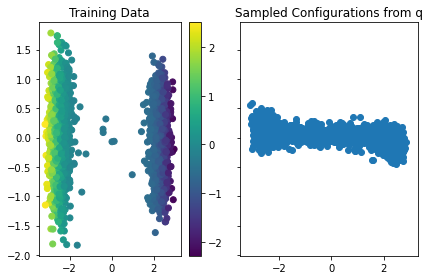

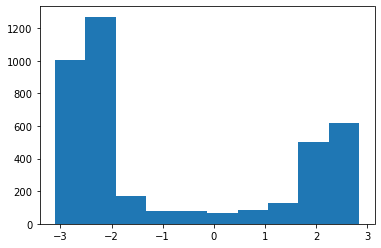

Epoch 98 Loss: -3539368.6055823774


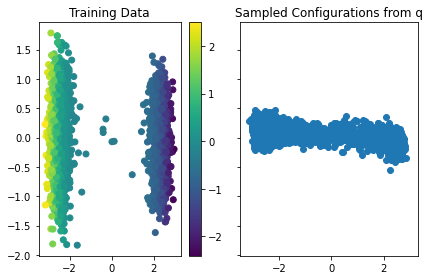

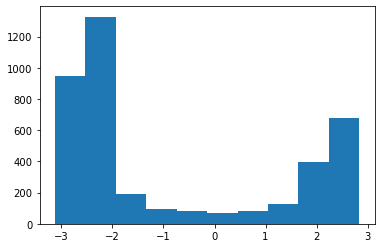

Epoch 99 Loss: -3553865.9414079734


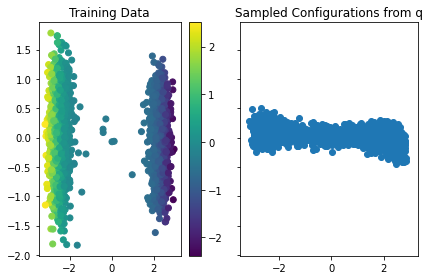

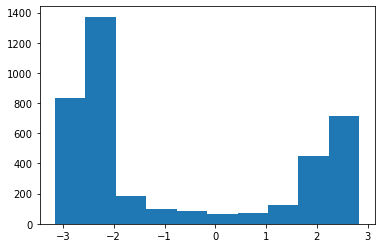

Epoch 100 Loss: -3535644.358015243


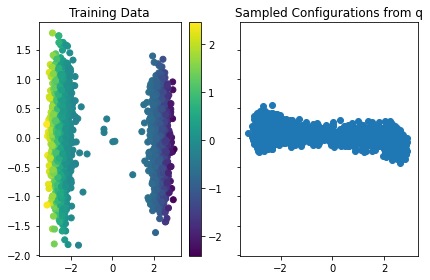

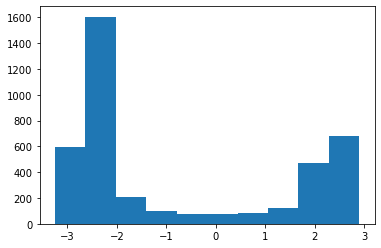

In [47]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mod = VAE().double()
mod = mod.to(device)
opt = torch.optim.Adam(mod.parameters(), lr = 1e-4,weight_decay = 1e-5)

# train
epochs = 100
L = 32 # number of monte carlo samples to estimate p(x | z) loss

for ep in range(epochs):
    mod.training = True
    train_loss = 0
    for batch_idx, data in enumerate(training_loader):
        
        # copy data to yield L monte carlo samples during forward pass
        dataaug = data[0].double().clone()
        for l in range(L - 1):
            dataaug = torch.cat((dataaug, data[0]), 0)
        data = torch.tensor(dataaug).to(device)
        
        opt.zero_grad()
        
        # forward pass
        recon_batch, mu_enc, logvar_enc = mod(data)
        mu_dec = recon_batch[0]
        logvar_dec = recon_batch[1]
        
        # backward pass
        loss = (N_train/batch_size)*VAEloss(mu_dec,logvar_dec,data,mu_enc,logvar_enc,L)
        loss.backward()
        opt.step()
        train_loss += loss.item()
        
    print("Epoch " + str(ep + 1) + " Loss: " + str(train_loss))
    
    # validation
    X_val = X_val.to(device)
    z = torch.randn(4000,1).double().to(device)
    with torch.no_grad():
        recon,mu_enc,_ = mod(X_val)
        mu_dec = recon[0]
        mu_gen,logvar_gen = mod.decode(z)
        x_gen = mu_gen + torch.exp(0.5*logvar_gen)*torch.randn(4000,2).double().to(device)
    
    X_np = X_val.cpu().numpy()
    mu_enc =  mu_enc.cpu().numpy()
    mu_dec = mu_dec.cpu().numpy()
    z = z.cpu().numpy().flatten()   
    x_gen = x_gen.cpu().numpy()
    
    fig, ax = plt.subplots(1,2,sharex = True, sharey = True)
    im1 = ax[0].scatter(X_np[:,0],X_np[:,1],c = mu_enc)
    ax[0].set_title('Training Data')
    fig.colorbar(im1,ax = ax[0])
    
    #ax[1].scatter(mu_dec[:,0],mu_dec[:,1])
    #ax[1].set_title('Reconstruction')
    ax[1].scatter(x_gen[:,0],x_gen[:,1])
    ax[1].set_title('Sampled Configurations from q')
    
    fig.tight_layout()
    plt.savefig('data_vae'+str(ep+1)+'.png')
    plt.show()
    plt.close()
    
    plt.hist(x_gen[:,0])
    plt.show()
    plt.close()